In [14]:
import math
from timeit import default_timer as timer
from typing import Iterable, List
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output

plt.rcParams.update({'font.size': 16})
sns.set_style('whitegrid')

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [15]:
from logging import exception
import ast
test = "It 's so much easier to navigate through the operating system , to find files , and it runs a lot faster !####[([9, 10], [4], 'POS'), ([18], [21], 'POS'), ([6], [4], 'POS'), ([13, 14], [21], 'POS')]"
def str_to_ans(test):
    if len(test.split('####')) == 1:
        return ['', '']
    test_str_items = test.split('####')[0].split()
    tmp = ast.literal_eval(test.split('####')[1])
    ans = ''
    for elem1 in tmp:
        for i, elem2 in enumerate(elem1):
            if i == 1:
                ans += '- '
            if i == 2:
                ans += '~ '
                ans += elem2
            if i != 2:
                for elem3 in elem2:
                    ans += test_str_items[elem3] + ' ' + str(elem3) + ' '
        ans += ' | '
    return [" ".join([f"{word} {i}" for i, word in enumerate(test_str_items)]), ans[:-3]]

In [16]:
def Database(split, pair=(0, 1)):
    file_path = 'data/val.txt'
    if split == 'train':
        file_path = 'data/train.txt'
    dataset = []
    with open(file_path, 'r') as file:
        for line in file:
            dataset.append(str_to_ans(line))

    return dataset

In [17]:
SRC = 'en'
TGT = 'de'

token_transform = {}
vocab_transform = {}

token_transform[SRC] = get_tokenizer(None)
token_transform[TGT] = get_tokenizer(None)

In [18]:
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    index_ = {SRC: 0, TGT: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[index_[language]])

In [19]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC, TGT]:
    train_iter = Database(split='train', pair=(SRC, TGT))
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC, TGT]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [20]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


# seq2seq через RNN и трансформер

In [22]:
class Seq2SeqRNN(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.rnn_encoder = nn.RNN(emb_size, emb_size, num_layers=num_encoder_layers)
        self.rnn_decoder = nn.RNN(emb_size, emb_size, num_layers=num_decoder_layers)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        src_emb, _ = self.rnn_encoder(src_emb)
        tgt_emb, _ = self.rnn_decoder(tgt_emb)

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))

        src_emb, _ = self.rnn_encoder(src_emb)

        return src_emb

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))

        tgt_emb, _ = self.rnn_decoder(tgt_emb)

        return self.transformer.decoder(tgt_emb, memory, tgt_mask)

In [23]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.tgt_tok_emb(tgt)), memory,
            tgt_mask)

In [24]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [25]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input

    return func


def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))


text_transform = {}
for ln in [SRC, TGT]:
    text_transform[ln] = sequential_transforms(token_transform[ln],
                                               vocab_transform[ln],
                                               tensor_transform)


def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [26]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('MSE')
    plt.show()

In [27]:
def train_epoch(model, optimizer, scheduler, max_iters, now_iter, train_dataloader):
    model.train()
    losses = 0

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        tmp = logits.argmax(dim=2)[:-1, :].detach().to('cpu')
        sz = tmp.shape[1]
        new_tgt_out = torch.cat((tmp,
                                 torch.tensor([[EOS_IDX] * sz]))).to(DEVICE)
        loss2 = loss_fn(logits.reshape(-1, logits.shape[-1]), new_tgt_out.reshape(-1))
        loss1 = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        alpha = now_iter / max_iters * 0.1
        loss = (1 - alpha) * loss1 + alpha * loss2
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        losses += loss.item()

    return losses / len(train_dataloader)

In [28]:
def evaluate(model, val_dataloader):
    model.eval()
    losses = 0

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [29]:
def train_and_validate(model, optimizer, scheduler, train_loader, val_loader,
                       num_epochs, verbose=True):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader
        loss = train_epoch(model, optimizer, scheduler, num_epochs, epoch, pbar)

        train_losses += [loss]
        train_metrics += [loss]

        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        loss = evaluate(model, pbar)

        val_losses += [loss]
        val_metrics += [loss]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)


    return train_metrics[-1], val_metrics[-1]

In [30]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC])
TGT_VOCAB_SIZE = len(vocab_transform[TGT])

Смена гиперпараметров

In [31]:
EMB_SIZE = 512 # !!!
NHEAD = 8
FFN_HID_DIM = 512 # !!!
BATCH_SIZE = 128 # !
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROPOUT = 0.3 # in [0,1] # !!!

In [32]:
model_size = EMB_SIZE
warmup_steps = 550 # !!
def warmup(step):
    return (model_size ** (-0.5) *
            min(max(1, step) ** (-0.5), max(1, step) * warmup_steps ** (-1.5)))

In [33]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROPOUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.02) # Уменьшать размытие?

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.3, betas=(0.9, 0.98), eps=1e-9) # ! lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup)

train_iter = Database(split='train', pair=(SRC, TGT))
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_iter = Database(split='valid', pair=(SRC, TGT))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

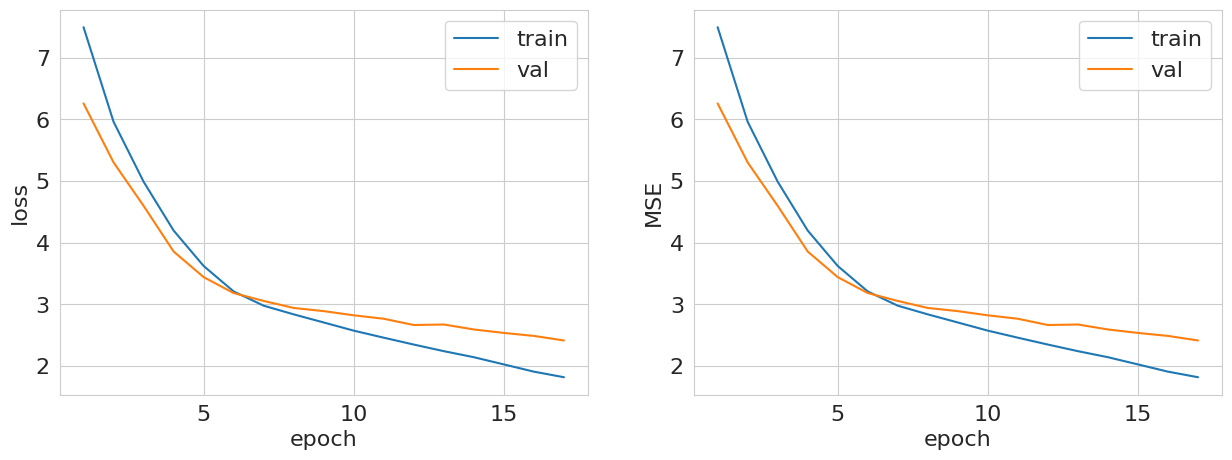

In [ ]:
num_epochs = 35

train_and_validate(transformer, optimizer, scheduler, train_loader, val_loader, num_epochs, verbose=True)



# print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s")

# Сохранение модели

In [ ]:
checkpoint = {'model': transformer.state_dict(),
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict()}
torch.save(checkpoint, 'model_ch.pth')

# Загрузка модели

In [ ]:
checkpoint = torch.load('model_ch.pth')
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROPOUT)
transformer.load_state_dict(checkpoint['model'])
transformer.to(DEVICE)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.3, betas=(0.9, 0.98), eps=1e-9) # ! lr
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup)
scheduler.load_state_dict(checkpoint['scheduler'])


# Продолжение

In [ ]:
num_epochs = 10

train_and_validate(transformer, optimizer, scheduler, train_loader, val_loader, num_epochs, verbose=True)

# Тестирование

In [ ]:
def sequence_length_penalty(length: int, alpha: float = 0.6) -> float:
    return ((5 + length) / (5 + 1)) ** alpha


def beam_search(model, src, src_mask, max_len, start_symbol, beam_size):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    all_vars = []
    ys_all = torch.ones(1, 1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    scores = torch.zeros(1, 1).to(DEVICE)
    for sas in range(max_len-1):
        # print(sas)
        memory = memory.to(DEVICE)
        new_scores = None
        new_ys = None
        for i, ys in enumerate(ys_all):
            tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                        .type(torch.bool)).to(DEVICE)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            tmp = scores[0][i] + torch.nn.LogSoftmax(dim=1)(prob) / sequence_length_penalty(sas + 1)
            val, ind = torch.topk(tmp, beam_size)
            if i == 0:
                new_scores = val
            else:
                new_scores = torch.cat([new_scores, val], dim=1)
            for j in ind[0]:
                ys_now = torch.cat([ys,
                            torch.ones(1, 1).type_as(src.data).fill_(j.item())], dim=0)
                if new_ys is None:
                    new_ys = ys_now.unsqueeze(0)  # .transpose(0, 1)
                else:
                    new_ys = torch.cat([new_ys, ys_now.unsqueeze(0)], dim=0)
        all_vars += list(zip(new_ys[new_ys[:, -1, 0] == EOS_IDX,:, 0], new_scores[0, new_ys[:, -1, 0] == EOS_IDX]))
        if (new_ys[:, -1, 0] == EOS_IDX).sum() == new_ys.shape[0]:
            break
        ys_all = new_ys[new_ys[:, -1, 0] != EOS_IDX,:, :]
        scores = new_scores[:, new_ys[:, -1, 0] != EOS_IDX]
        _, ind = torch.topk(scores, min(beam_size, scores.shape[1]))
        scores = scores[:, ind[0]]
        ys_all = ys_all[ind[0], :, :]
    all_vars += list(zip(ys_all[:, :, 0], scores[0,:]))
    # print(len(all_vars))
    ans = max(all_vars, key=lambda e: e[1])[0]
    # print(ans)
    return ans


def test(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = beam_search(
        model,  src, src_mask, max_len=num_tokens + 15, start_symbol=BOS_IDX, beam_size=3).flatten()
    ans = " ".join(vocab_transform[TGT].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")
    return ans

In [ ]:
transformer.eval()
with open("translate.txt", 'w') as end:
    with open("data/test.txt", 'r') as file:
        for line in file:
            ans = test(transformer, str_to_ans(line)[0])
            end.write(ans + '\n')